DEEP LEARNING PROJECT

PROBLEM STATEMENT: AI diagnostics in bone oncology for predicting bone metastasis in lung cancer patients

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Load pre-trained VGG16 model without the top (classification) layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in VGG16 so they are not trained again
for layer in base_model.layers:
    layer.trainable = False


In [3]:
# Modify the final output layer to match the number of classes 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Use 'softmax' for multi-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define your dataset directory and target directories for split
dataset_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset"
train_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset/train"
val_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset/val"
test_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset/test"

# Create directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Minimum samples required for a class to proceed
min_samples = 2

# Iterate over each class folder in the dataset directory
print("Classes in dataset directory:")
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        # Get all image files in the class folder, excluding hidden files
        all_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        all_files = [os.path.join(class_path, file) for file in all_files]

        print(f"Checking class path: {class_path} - Found {len(all_files)} files")

        # Only proceed if there are enough samples
        if len(all_files) >= min_samples:
            if len(all_files) == 2:
                # If there are exactly 2 images, use one for training and one for testing
                train_files = all_files[:1]
                test_files = all_files[1:]
                val_files = []
            else:
                # Split the files into train and remaining (for validation and test)
                train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)  # 70% train, 30% temp
                val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # 50% of the remaining for val and test

            # Create class directories in the target directories
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Move files to their respective directories
            for file in train_files:
                shutil.move(file, os.path.join(train_dir, class_name))
            for file in val_files:
                shutil.move(file, os.path.join(val_dir, class_name))
            for file in test_files:
                shutil.move(file, os.path.join(test_dir, class_name))
        else:
            print(f"Skipping class '{class_name}' due to insufficient samples: {len(all_files)} found.")

print("Data split completed.")


Classes in dataset directory:
Checking class path: C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Bengin cases - Found 0 files
Skipping class 'Bengin cases' due to insufficient samples: 0 found.
Checking class path: C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Malignant cases - Found 0 files
Skipping class 'Malignant cases' due to insufficient samples: 0 found.
Checking class path: C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Normal cases - Found 0 files
Skipping class 'Normal cases' due to insufficient samples: 0 found.
Checking class path: C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Pre

In [5]:
img_height, img_width = 224, 224
# Created ImageDataGenerators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,  # Increase shift range
    height_shift_range=0.3,  # Increase shift range
    shear_range=0.2,
    zoom_range=0.3,  # Increase zoom range
    brightness_range=[0.8, 1.2],  # New: Adjust brightness
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your case
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your case
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',  # or 'binary', depending on your case
    shuffle=False  # Important for evaluation
)

Found 767 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(
    train_generator,
    epochs=1000,  # Adjust as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
      # Add the callback here
)


C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.4059 - loss: 1.3903 - val_accuracy: 0.5875 - val_loss: 0.8262
Epoch 2/1000
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:07 3s/step - accuracy: 0.5000 - loss: 1.0138

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 643ms/step - accuracy: 0.5000 - loss: 1.0138 - val_accuracy: 0.5250 - val_loss: 0.8581
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5495 - loss: 1.1175 - val_accuracy: 0.6687 - val_loss: 0.8100
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 650ms/step - accuracy: 0.5484 - loss: 0.9865 - val_accuracy: 0.6750 - val_loss: 0.7935
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.6070 - loss: 0.9390 - val_accuracy: 0.7063 - val_loss: 0.6675
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 685ms/step - accuracy: 0.5312 - loss: 1.0294 - val_accuracy: 0.6875 - val_loss: 0.7006
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.6391 - loss: 0.7831 - val_accuracy: 0.7250 - val_loss: 0.6307
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 651ms/step - accuracy: 0.6562 - loss: 0.6891 - val_accuracy: 0.7625 - val_loss: 0.6333
Epoch 9/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.6752 - loss: 0.7448 - val_accuracy: 0.7

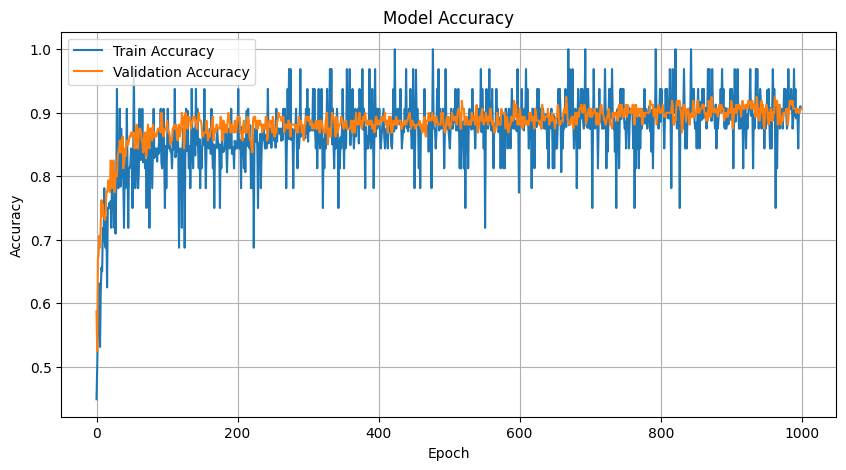

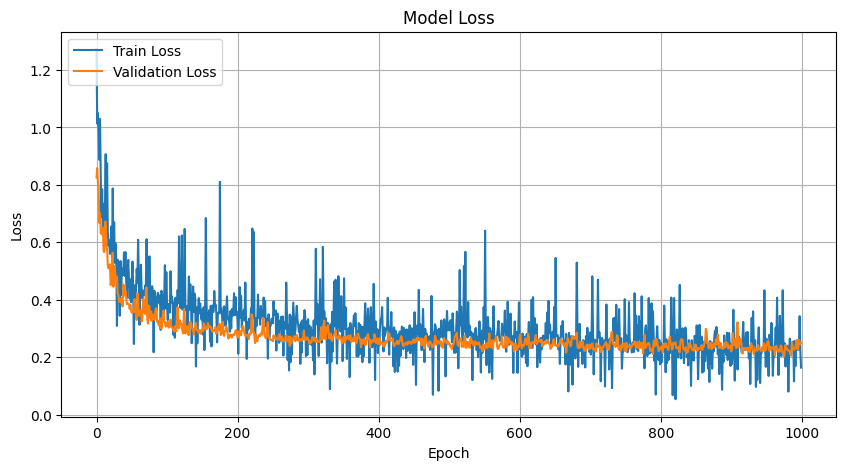

In [7]:
import matplotlib.pyplot as plt

# Plot the accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visualization
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history: # Check if validation accuracy exists
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()  # Optional: Add grid for better readability
    plt.show()

# Plot the loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visualization
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:  # Check if validation loss exists
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()  # Optional: Add grid for better readability
    plt.show()

# Call the plot functions
plot_accuracy(history)
plot_loss(history)


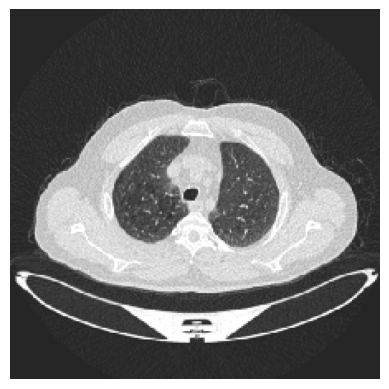

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Predicted class: benign
Prediction confidence: 81.18%


In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt



# Path to the image you want to predict
image_path = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test\Normal cases\Normal case (1).jpg"

# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


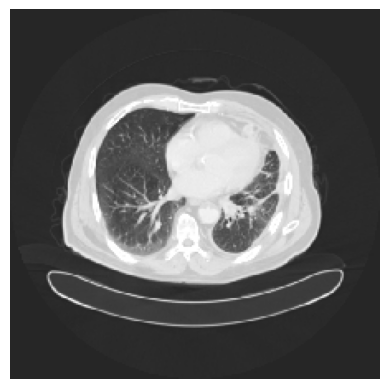

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted class: malignant
Prediction confidence: 100.00%


In [9]:
image_path = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test\Malignant cases\Malignant case (1).jpg"

# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


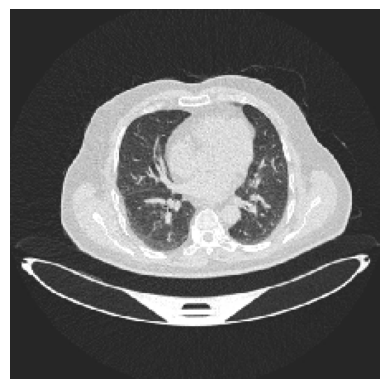

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted class: normal
Prediction confidence: 54.33%


In [10]:
image_path = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test\Bengin cases\Bengin case (1).jpg"
# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
True labels: 166, Predictions: 166


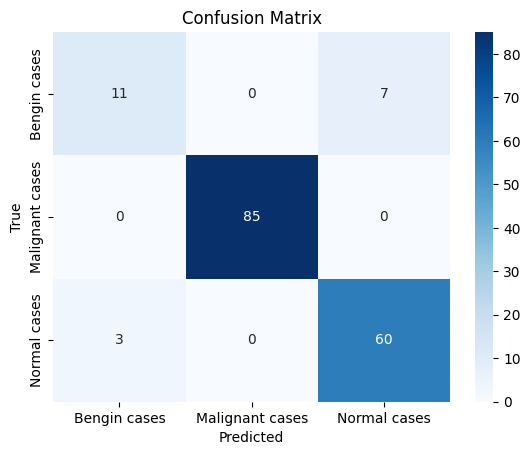

                 precision    recall  f1-score   support

   Bengin cases       0.79      0.61      0.69        18
Malignant cases       1.00      1.00      1.00        85
   Normal cases       0.90      0.95      0.92        63

       accuracy                           0.94       166
      macro avg       0.89      0.85      0.87       166
   weighted avg       0.94      0.94      0.94       166



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Ensure sizes match
print(f"True labels: {len(true_classes)}, Predictions: {len(test_pred_classes)}")

# Confusion Matrix
cm = confusion_matrix(true_classes, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=list(test_generator.class_indices.keys())))

